<a href="https://colab.research.google.com/github/fezjo/ml-project/blob/master/ml_project_ciz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://github.com/fezjo/ml-project/raw/master/chat_history.zip
!unzip -o -Pfmfilords chat_history.zip
!pip install unidecode
!pip install gradio

--2023-01-31 14:08:52--  https://github.com/fezjo/ml-project/raw/master/chat_history.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fezjo/ml-project/master/chat_history.zip [following]
--2023-01-31 14:08:53--  https://raw.githubusercontent.com/fezjo/ml-project/master/chat_history.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2804699 (2.7M) [application/zip]
Saving to: ‘chat_history.zip.1’

chat_history.zip.1  100%[===================>]   2.67M  --.-KB/s    in 0.04s   

2023-01-31 14:08:53 (70.5 MB/s) - ‘chat_history.zip.1’ saved [2804699/2804699]

Archive:  chat_history.zip
  inflatin

In [2]:
from matplotlib import pyplot as plt

def plot_history(history):
  dpi = 100
  plt.figure(dpi=dpi)
  plt.plot(history.history['loss'], label='training loss')
  plt.plot(history.history.get('val_loss', []), label='validation loss')
  plt.legend(loc='best')

  plt.figure(dpi=dpi)
  plt.plot(history.history['accuracy'], label='train accuracy')
  plt.plot(history.history.get('val_accuracy', []), label='validation accuracy')
  plt.legend(loc='best')
  plt.show()

In [3]:
import json

with open("chat_history.json") as chf:
  data = json.load(chf)

In [4]:
from unidecode import unidecode

author_blacklist = {"PollBot", "Dartboi", "Telelog"}
authors = dict()
messages = []
for message in data["messages"]:
  if message["type"] != "message":
    continue
  text_entities, author = message["text_entities"], message["from"]
  if not text_entities or author in author_blacklist:
    continue
  text_chunks = []
  for entity in text_entities:
    text_chunks.append(entity["text"])
  text = "".join(text_chunks)
  text = unidecode(text).lower()
  authors.setdefault(author, len(authors))
  messages.append((text, authors[author]))

print(authors)
print(messages[:100])

{'Jozef': 0, 'Bohdanator': 1, 'Daniel Oravec': 2, 'Samuel Čavoj': 3, 'Dávid Mišiak': 4, 'Pavol Kebis': 5, 'Jaroslav Paška': 6, 'Ján Priner': 7}
[('make me admin pls', 0), ('sure :d :d', 1), ('aj mna!!', 2), ('aj mna!!!', 3), ('', 3), ('wtf', 1), ('ono to islo dokelu tak rychlo...', 1), ('neviem, co si cakal, ze sa stane, ked z jozefa spravis admina', 3), ('nespravil som :d :d', 1), ('jaj', 3), ('zabudol som nastavit aby sa to nedialo', 1), (':(', 2), ('genialne', 3), ('kde su vsetky prvacky?', 0), ('co tu robi paska?', 3), ('flexi', 0), ('ani nie', 3), ('tu neexistuje demokracia', 1), ('preco ste dnes neboli v skole?', 2), ('just kidding', 1), ('podme sa bavit o kamenoch', 1), ('lebo som bol na orave', 1), ('rebels', 4), ('pridte na vba231', 0), ('?', 4), ('kedy sa zacina skola?', 0), ('vyzera to tak ze v pondelok', 4), ('cas?', 0), ('asi podla rozvrhu', 4), ('alebo to mecheche otvorenie akademickeho roka', 4), ('neviem ktore z toho', 4), ('vie niekto?', 4), ('podla mna normalne podla 

In [5]:
author_activity = [0] * len(authors)
for message in messages:
  author_activity[message[1]] += 1

for author, activity in zip(authors.items(), author_activity):
  print("{}: {} [{:.2%}]".format(author, activity, activity / len(messages)))

('Jozef', 0): 17808 [27.98%]
('Bohdanator', 1): 6326 [9.94%]
('Daniel Oravec', 2): 6078 [9.55%]
('Samuel Čavoj', 3): 17254 [27.11%]
('Dávid Mišiak', 4): 15336 [24.10%]
('Pavol Kebis', 5): 489 [0.77%]
('Jaroslav Paška', 6): 21 [0.03%]
('Ján Priner', 7): 328 [0.52%]


In [6]:
import numpy as np

ml_stats = []
for len_fun in (lambda m: len(m[0]), lambda m: len(m[0].split())):
    message_lengths = np.array(list(map(len_fun, messages)))
    sml = sorted(message_lengths)
    ml_avg, ml_std = np.mean(message_lengths), np.std(message_lengths)
    print(f"message length / avg: {ml_avg:.2f} / std: {ml_std:.2f}")
    for r in (0.5, 0.68, 0.9, 0.95, 0.99, 0.997, 1):
        i = min(len(sml) - 1, int(len(sml) * r))
        print(r, sml[i])
    print()
    ml_stats.append((ml_avg, ml_std))

message length / avg: 34.47 / std: 60.23
0.5 23
0.68 35
0.9 72
0.95 98
0.99 189
0.997 326
1 4095

message length / avg: 6.31 / std: 8.64
0.5 4
0.68 7
0.9 13
0.95 18
0.99 33
0.997 53
1 610



In [7]:
perm = np.random.permutation(len(messages))
shuffled_messages = [messages[i] for i in perm]
X, Y = map(lambda k: np.array([m[k] for m in shuffled_messages]), (0, 1))
train_test_ratio = 0.8
num_train = int(train_test_ratio * len(X))
X_train, X_test = np.split(X, [num_train])
Y_train, Y_test = np.split(Y, [num_train])
output_shape = len(authors)

print(X[:100])
print(Y[:100])
print(X.shape, X_train.shape, X_test.shape)
print(Y.shape, Y_train.shape, Y_test.shape)

['poslal som uz davno, ale kasle na mna' 'fakin w3schools'
 'v chate v cviceniach?' 'budete robit nejaky write cache?'
 'proste, ten mf vscode nevie doplnat'
 'fakin boli ma pravy ukazovak, takze pisem este polovicnym tempom ako normalne'
 '"odpisujete a este aj zle!"'
 '@danza3 vies nam povedat co boli priblizne otazky?'
 'takze ak ty si majitel 15.16.0.0/16, tak je na nejaky tvoj nameserver namierena cela domena 16.15.in-addr.arpa'
 'a teda iba pastiku (alebo nejaku vec co maju matici), zps nie, tak neviem ci si to vobec budeme moct dat :d'
 'len ze chces co najviac podmienok vymysliet' '16:30 dame call?' 'jooj'
 'google so svojim megamozgom' 'ja hovorim ze budu tri rozne znamky'
 'mal by si ich zazalovat palo'
 'som hladny a chcem sa hrat cyberpunk a boli ma chrbat'
 'tie synonyma su asi fajn, ale vobec to nechape kontext, takze niekedy su tie synonyma uplne mimo'
 'ale zapa tiez' 'heslo je vendojelama'
 'ale nezda sa mi ze pri 94 znakovej abecede by ludia mali len o jeden bit viac 

In [8]:
import tensorflow as tf
from tensorflow import keras


# Use the TextVectorization layer to tokenize the input string based on bigrams
sequence_dim_from_stats = lambda stat: int(stat[0] + 2 * stat[1]) * 2
bigram_sequence_dim = sequence_dim_from_stats(ml_stats[0])
preprocessing_char = keras.layers.TextVectorization(
    standardize=None,
    split=tf.strings.bytes_split,
    ngrams=2,
    output_sequence_length=bigram_sequence_dim)
preprocessing_char.adapt(X_train)

word_sequence_dim = sequence_dim_from_stats(ml_stats[1])
preprocessing_word = keras.layers.TextVectorization(
    ngrams=2,
    output_sequence_length=word_sequence_dim,
    max_tokens=10000)
preprocessing_word.adapt(X_train)

# Input layer for string data
inputs = keras.layers.Input(shape=(1,), dtype=tf.string)

channels = []
for preprocessing in (preprocessing_char, preprocessing_word):
    # Preprocessing layer
    layer = preprocessing(inputs)

    # Embedding layer
    max_vocab_size = len(preprocessing.get_vocabulary()) + 1
    print(f"Vocabulary size: {max_vocab_size}")
    embedding_dim = 300
    layer = keras.layers.Embedding(
        input_dim=max_vocab_size,
        output_dim=embedding_dim,
    #     embeddings_regularizer="l1",
    )(layer)

    # Add a dropout layer to prevent overfitting
    layer = keras.layers.Dropout(rate=0.25)(layer)

    # Add dimension for channel needed by convolution
    layer = keras.layers.Reshape(target_shape=(*layer.shape[-2:], 1))(layer)

    # # Create 3 parallel branches for convolution with varying window widths
    n_conv_filters = 500 # TODO
    parent_layer = layer
    child_layers = []
    for ks in (3, 4, 5):
        layer = parent_layer

        layer = keras.layers.Conv2D(
            filters=n_conv_filters,
            kernel_size=(ks, embedding_dim),
            activation="selu")(layer)

        # Max pooling layer
        layer = keras.layers.GlobalMaxPooling2D()(layer)
        child_layers.append(layer)

    # Concatenate the outputs of the parallel Conv1D layers
    layer = keras.layers.Concatenate()(child_layers)
    
    channels.append(layer)


# Concatenate the outputs of the char and word channels
layer = keras.layers.Concatenate()(channels)

# # Add a dropout layer to prevent overfitting
layer = keras.layers.Dropout(rate=0.6)(layer)

# # Add a dense layer
# layer = keras.layers.Dense(units=300, activation="relu")(layer)

# Output layer
outputs = keras.layers.Dense(units=output_shape, activation="softmax")(layer)

# Create the model
model = keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(0.0002),
    loss="categorical_crossentropy",
    metrics=["accuracy"])
model.summary()

2023-01-31 14:09:07.908136: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 14:09:07.918192: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 14:09:07.918934: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 14:09:07.920125: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Vocabulary size: 3511
Vocabulary size: 10001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 308)          0           input_1[0][0]                    
__________________________________________________________________________________________________
text_vectorization_1 (TextVecto (None, 46)           0           input_1[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 308, 300)     1053300     text_vectorization[0][0]         
_________________________________________________

In [9]:
for preprocessing in (preprocessing_char, preprocessing_word):
    print(preprocessing.get_vocabulary()[:100])

['', '[UNK]', ' ', 'a', 'e', 'o', 't', 'i', 'n', 's', 'm', 'l', 'r', 'd', 'k', 'e  ', 'p', 'u', 'v', 'c', 'z', 'o  ', 'a  ', '  t', 'j', '  s', 'y', 'b', 'h', '  n', 't o', 'n e', '  p', 'm  ', '  a', 'i  ', 'a k', 'a l', '  m', 'n a', 't a', 'i e', '  z', 's t', 't e', 'p r', '  v', 's i', 'y  ', 'l e', ',', 'o m', ',  ', 'n i', 'p o', 'r a', 'm a', 'j e', 'r e', '?', 'k o', 'a t', 't  ', 'e d', '  d', 'f', 'o v', '  j', '  c', 'u  ', 'e n', 'z e', 'l  ', '  b', 'a m', 'a s', 's a', 'e s', 'r o', 'i n', 'c h', 'd a', 'e m', 'd e', 'c i', 's  ', 'a n', '  k', 'k  ', 'l a', 'v i', 'v e', 'e r', 's o', 't i', '.', 'v a', 'n o', 'i s', 'd o']
['', '[UNK]', 'to', 'a', 'je', 'ze', 'som', 'sa', 'na', 'si', 'ale', 'tak', 'v', 'nie', 'co', 'ako', 'ja', 'uz', 'by', 'aj', 'asi', 'tam', 'd', 'ked', 'mi', 'je to', 'ma', 'ten', 'z', 'no', 'o', 'alebo', 'mam', 's', 'este', 'do', 'su', 'ci', 'bude', 'tie', 'lebo', 'ano', 'proste', 'ak', 'nieco', 'ti', 'to je', 'fakin', 'tu', 'neviem', 'mozno', 'len',

In [10]:
sample_text = "fakin ak si nic nedas, tak PON UTO PIA mas???!? cely den na pracu a este streda poobede :D 👍 @fezjo"

inp = model.input                                           # input placeholder
model_outputs = [layer.output for layer in model.layers]          # all layer outputs
functor = lambda outputs: keras.backend.function(inp, outputs)   # evaluation function

# Testing
for output in model_outputs[:3]:
  print(functor([output])(np.array([sample_text])))

[array([[b'fakin ak si nic nedas, tak PON UTO PIA mas???!? cely den na pracu a este streda poobede :D \xf0\x9f\x91\x8d @fezjo']],
      dtype=object)]
[array([[  65,    3,   14,    7,    8,    2,    3,   14,    2,    9,    7,
           2,    8,    7,   19,    2,    8,    4,   13,    3,    9,   50,
           2,    6,    3,   14,    2,    1,    1,    1,    2,    1,    1,
           1,    2,    1,    1,    1,    2,   10,    3,    9,   59,   59,
          59,  274,   59,    2,   19,    4,   11,   26,    2,   13,    4,
           8,    2,    8,    3,    2,   16,   12,    3,   19,   17,    2,
           3,    2,    4,    9,    6,    4,    2,    9,    6,   12,    4,
          13,    3,    2,   16,    5,    5,   27,    4,   13,    4,    2,
         152,    1,    2,    1,    1,    1,    1,    2,  278,   65,    4,
          20,   24,    5,  218,   36,  267,   79,  118,   34,   36,   88,
          25,   47,   35,   29,   53,  154,  220,   29,   31,   63,   81,
          75,  452,   52,   23,   

Epoch 1/6


2023-01-31 14:09:21.716824: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


90/90 [==============================] - 45s 465ms/step - loss: 1.5944 - accuracy: 0.3313 - val_loss: 1.5174 - val_accuracy: 0.3804
Epoch 2/6
90/90 [==============================] - 40s 449ms/step - loss: 1.4856 - accuracy: 0.3949 - val_loss: 1.4673 - val_accuracy: 0.4124
Epoch 3/6
90/90 [==============================] - 40s 450ms/step - loss: 1.4099 - accuracy: 0.4433 - val_loss: 1.4222 - val_accuracy: 0.4413
Epoch 4/6
90/90 [==============================] - 41s 450ms/step - loss: 1.3170 - accuracy: 0.4942 - val_loss: 1.3961 - val_accuracy: 0.4491
Epoch 5/6
90/90 [==============================] - 40s 449ms/step - loss: 1.2277 - accuracy: 0.5355 - val_loss: 1.3954 - val_accuracy: 0.4546
Epoch 6/6
90/90 [==============================] - 40s 450ms/step - loss: 1.1525 - accuracy: 0.5667 - val_loss: 1.4087 - val_accuracy: 0.4607


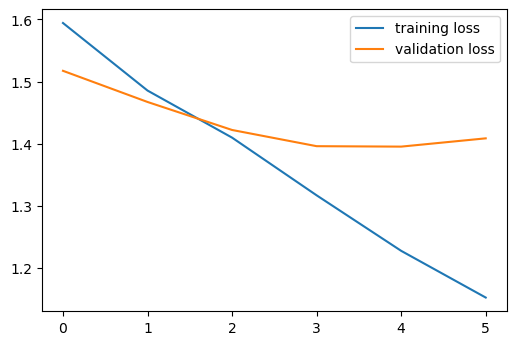

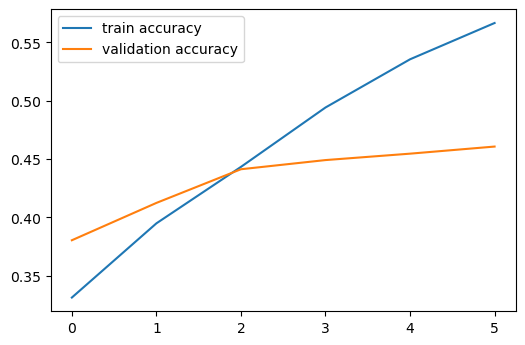

In [11]:
history = model.fit(**{
    "x": X_train,
    "y": keras.utils.to_categorical(Y_train),
    "epochs": 6,
    "batch_size": 512,
    "validation_split": 0.10,
    "verbose": 1,
    })

plot_history(history)

In [12]:
print(authors)
inv_authors = {v:k for k, v in authors.items()}
sample_num = 100
prediction = model.predict(X_test[:sample_num])
for pred, x, y in zip(prediction, X_test, Y_test):
    py = pred.argmax()
    print(f"correct={y==py} real={y} pred={py} {list(map(lambda x: round(x*100), pred))}\n{inv_authors[y]}: {x}")

{'Jozef': 0, 'Bohdanator': 1, 'Daniel Oravec': 2, 'Samuel Čavoj': 3, 'Dávid Mišiak': 4, 'Pavol Kebis': 5, 'Jaroslav Paška': 6, 'Ján Priner': 7}
correct=False real=1 pred=0 [28, 15, 26, 11, 17, 2, 0, 1]
Bohdanator: kto mate poruke nalozite mi sem pls linky na vsetky predmety? zabudol som zalozkovat
correct=True real=3 pred=3 [3, 1, 1, 95, 1, 0, 0, 0]
Samuel Čavoj: lmao
correct=True real=4 pred=4 [6, 5, 1, 2, 84, 1, 0, 0]
Dávid Mišiak: najcastejsia bola ze im ukazali nejaky pravouhly trojuholnik a spytali sa co o nom hovori pytagorova veta, a 61% deti odpovedalo a^2+b^2=c^2, hoci boli tie strany oznacene uplne inak
correct=True real=4 pred=4 [30, 12, 11, 12, 31, 2, 0, 1]
Dávid Mišiak: (4 viem ze mam zle, 1 a 3 velmi dufam ze mam aspon vacsinu dobre)
correct=True real=3 pred=3 [25, 6, 22, 31, 15, 0, 0, 1]
Samuel Čavoj: ano
correct=True real=3 pred=3 [13, 25, 12, 30, 19, 1, 0, 1]
Samuel Čavoj: pride mi to ako fakt otrava
correct=False real=4 pred=3 [32, 4, 2, 34, 28, 0, 0, 0]
Dávid Mišiak:

In [13]:
train_score = model.evaluate(X_train, tf.keras.utils.to_categorical(Y_train))
print("\n\ntrain loss: {} | train acc: {}\n".format(train_score[0], train_score[1]))

test_score = model.evaluate(X_test, tf.keras.utils.to_categorical(Y_test))
print("\n\ntest loss: {} | test acc: {}".format(test_score[0], test_score[1]))

1591/1591 [==============================] - 19s 12ms/step - loss: 1.0889 - accuracy: 0.5997


train loss: 1.0889201164245605 | train acc: 0.5996817946434021

398/398 [==============================] - 5s 12ms/step - loss: 1.4147 - accuracy: 0.4481


test loss: 1.4147474765777588 | test acc: 0.44806724786758423


```
Epoch 1/10
716/716 [==============================] - 27s 36ms/step - loss: 1.4964 - accuracy: 0.3837 - val_loss: 1.4383 - val_accuracy: 0.4183
Epoch 2/10
716/716 [==============================] - 25s 36ms/step - loss: 1.4131 - accuracy: 0.4310 - val_loss: 1.3970 - val_accuracy: 0.4354
Epoch 3/10
716/716 [==============================] - 25s 36ms/step - loss: 1.3427 - accuracy: 0.4655 - val_loss: 1.3826 - val_accuracy: 0.4470
Epoch 4/10
716/716 [==============================] - 25s 36ms/step - loss: 1.2733 - accuracy: 0.4990 - val_loss: 1.3885 - val_accuracy: 0.4440
Epoch 5/10
716/716 [==============================] - 25s 35ms/step - loss: 1.1959 - accuracy: 0.5339 - val_loss: 1.3993 - val_accuracy: 0.4521
Epoch 6/10
716/716 [==============================] - 25s 35ms/step - loss: 1.1183 - accuracy: 0.5708 - val_loss: 1.4258 - val_accuracy: 0.4544
Epoch 7/10
716/716 [==============================] - 25s 35ms/step - loss: 1.0404 - accuracy: 0.5998 - val_loss: 1.4407 - val_accuracy: 0.4487
Epoch 8/10
716/716 [==============================] - 25s 35ms/step - loss: 0.9775 - accuracy: 0.6283 - val_loss: 1.4890 - val_accuracy: 0.4476
Epoch 9/10
716/716 [==============================] - 25s 35ms/step - loss: 0.9131 - accuracy: 0.6558 - val_loss: 1.5166 - val_accuracy: 0.4470
Epoch 10/10
716/716 [==============================] - 25s 35ms/step - loss: 0.8509 - accuracy: 0.6859 - val_loss: 1.5764 - val_accuracy: 0.4550
```

{'Jozef': 0, 'Bohdanator': 1, 'Daniel Oravec': 2, 'Samuel Čavoj': 3, 'Dávid Mišiak': 4, 'Pavol Kebis': 5, 'Jaroslav Paška': 6, 'Ján Priner': 7}
Running on local URL:  http://127.0.0.1:7866
Running on public URL: https://c1085437-8da3-4437.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


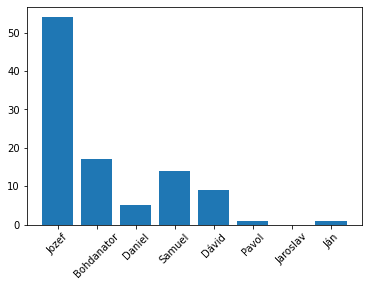

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/gradio/routes.py", line 350, in run_predict
    event_id=event_id,
  File "/opt/conda/lib/python3.7/site-packages/gradio/blocks.py", line 1015, in process_api
    data = self.postprocess_data(fn_index, result["prediction"], state)
  File "/opt/conda/lib/python3.7/site-packages/gradio/blocks.py", line 953, in postprocess_data
    prediction_value = block.postprocess(prediction_value)
  File "/opt/conda/lib/python3.7/site-packages/gradio/components.py", line 1534, in postprocess
    raise ValueError("Cannot process this value as an Image")
ValueError: Cannot process this value as an Image


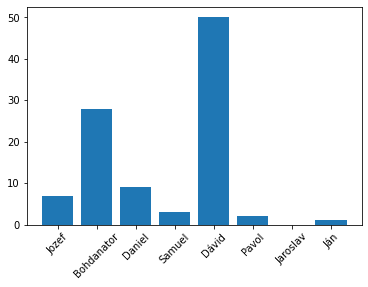

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/gradio/routes.py", line 350, in run_predict
    event_id=event_id,
  File "/opt/conda/lib/python3.7/site-packages/gradio/blocks.py", line 1015, in process_api
    data = self.postprocess_data(fn_index, result["prediction"], state)
  File "/opt/conda/lib/python3.7/site-packages/gradio/blocks.py", line 953, in postprocess_data
    prediction_value = block.postprocess(prediction_value)
  File "/opt/conda/lib/python3.7/site-packages/gradio/components.py", line 1534, in postprocess
    raise ValueError("Cannot process this value as an Image")
ValueError: Cannot process this value as an Image


In [40]:
import gradio as gr
import io

print(authors)
authors_names = list(map(lambda a: a[1].split()[0], sorted(inv_authors.items())))
def predict_author(text):
    text = unidecode(text).lower()
    pred = model.predict(np.array([text]))[0]
    pred_y = pred.argmax()
    confidence = list(map(lambda x: round(x*100), pred))
    author = inv_authors[pred_y]
    
    plt.xticks(rotation=45)
    plt.bar(authors_names, confidence)
    plt.show()
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    return author, buf, f"predicted_author {author} / pred_i={pred_y} confidence={confidence}"

iface = gr.Interface(
  fn=predict_author, 
  inputs='text',
  outputs=['text', 'image', 'text'],
  examples=[
      ["tak zalezi aj ze co je to za konverzaciu a ako velmi odlisni su ti ludia"],
      ["jaaaaaj v buse sme sa bavili uz si pamatam"],
      ["no tak taketo nieco by som ja povedal"]
  ]
)

iface.launch(share=True)